<span style="font-size:5em;">Neural network from scratch</span>

**Michał M.**

In this notebook I implement basic neural network using numpy and pandas. I do not use any well known frameworks as Tensorflow or Pytorch, it is just an exercise. I will publish it on Kaggle as a notebook for educational purposes.

The idea of this notebook is based on Jan Chorowski Neural Networks class conducted at Institute of Computer Science, University of Wrocław.

I will write the code first and then I would add some theory.

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Gradient descent

The Gradient Descent algorithm finds the minimum of a given function by taking small steps along the function's gradient. In pseudocode:

>$\Theta \leftarrow \Theta_0$
>
>**while** stop condition not met **do**
>
>$~~~~$$\Theta \leftarrow \Theta - \alpha \nabla_\Theta f(\Theta)$
>
>**end while**

where $f$ is the function to minimize, $\nabla_\Theta f(\Theta)$ denotes $f$'s gradient at $\Theta$ and $\alpha$ is the step size, taking typically values from $10^{-4},\ldots,10^{-1}$.

In [42]:
# GD optimizer

def GD(f, Theta0, alpha, stop_tolerance=1e-10, max_steps=1000000, verbose=False):
    """    
    Runs gradient descent algorithm on f.
    
    The basic iteration is:
    val, dVdTheta <- f(Theta)
    Theta <- -alpha * dVdTheta
    
    Parameters
    ----------
    f : function that when evalueted on a Theta of same dtype and shape as Theta0
        returns a tuple (value, dValdTheta) with dValdTheta of the same shape as Theta
        
    Theta0 : starting point
        
    alpha : step length
    
    stop_tolerance : stop iterations when improvement is below this threhsold
        
    max_steps : maximum number of steps
    
    Returns
    ----------
    Theta, history : tuple
        - Theta : optimal value of Theta
        - history : list of length num_steps containing tuples (Theta, (val, dValdTheta))
    """
    history = []
    
    Theta = Theta0
    value = np.inf
    
    step = 0
    while step < max_steps:
        previous_value = value
        value, gradient = f(Theta)
        history.append([Theta, (value, gradient)])
        
        if np.abs(previous_value-value) < stop_tolerance:
            break
        
        Theta = Theta - alpha*gradient
        
        step += 1
    
    history.append([Theta, f(Theta)])
    
    if verbose:
        print ("Found optimum at %s in %d steps." % (Theta, len(history)))
    
    return Theta, history

In [43]:
# Rosenbrock function

def rosenbrock_v(x, a=1, b=100):
    """  
    Returns the value of Rosenbrock's function.
    
    Parameters
    ----------
    x : arguments in a form of list with length 2
    
    a, b : parameters of Rosenbrock's function
            
    Returns
    ----------
    foo : float, value of Rosenbrock's function at x
    """
    return (a - x[0])**2 + b*(x[1] - x[0]**2)**2

def rosenbrock(x):
    """
    Returns the value of Rosenbrock's function and its gradient.
    
    Parameters
    ----------
    v : argument
    
    a, b : parameters of rose
            
    Returns
    ----------
    foo : ndarray of shape (2,)
        - value : value of Rosenbrock's function
        - dVdX : ndarray of shape (2,) containing gradient values 
    """
    a = 1
    b = 100
    value  = rosenbrock_v(x)
    dVdx0 = -2*(a - x[0]) - 2*b*(x[1]-x[0]**2) * 2*x[0]
    dVdx1 = 2*b * (x[1]-x[0]**2)
    dVdX = np.array([dVdx0, dVdx1])    
    return np.array([value, dVdX])

In [186]:
Xzero = [-0.45, 2.25]
Xopt, Xhist = GD(rosenbrock, Xzero, alpha=2e-3, stop_tolerance=1e-10, max_steps=1e6, verbose=True)

values_hist = [t[1][0] for t in Xhist]


x = np.arange(-2.25,2.25,0.01)
y = np.arange(-1,2.5,0.01)
X,Y = np.meshgrid(x,y)
Z = rosenbrock_v([X, Y])

Found optimum at [0.99975021 0.99949949] in 9243 steps.


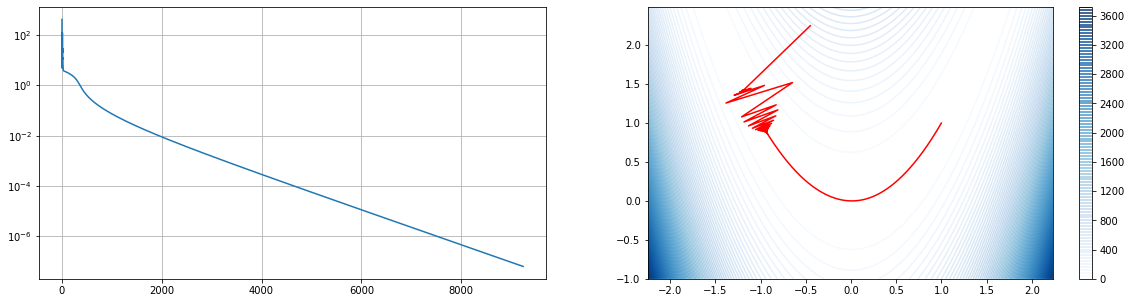

In [187]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

axes[0].grid()
axes[0].set_yscale("log")
axes[0].plot(values_hist)

axes[1].plot([t[0][0] for t in Xhist], [t[0][1] for t in Xhist], color='red')
im = axes[1].contour(X, Y, Z, 100, cmap='Blues')
fig.colorbar(im, ax=axes[1])

plt.show()